# Observational impacts from compound modes

This file grabs the observed rainfall and temperature anomalies for each yeah and season and matches them with the events identifed in the obsIndeces file

In [2]:
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [3]:
_work_dir='/g/data/gv90/as2285/compound'

import sys
sys.path.append(_work_dir)

import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils._indexDefinitions as _index

%run {_work_dir}/helpers/impactPlots.ipynb
%run {_work_dir}/utils/emergence.ipynb

# Load the Data

In [4]:
eventsXr=xarray.open_dataset(f'{_work_dir}/results/obsEvents.nc').sel(year=slice(1940,2019))

In [5]:
#anoms have already been calculated - see prelim/adcdPrTAnoms.ipynb file
impactXr=xarray.open_dataset(f'{_work_dir}/results/observPrTmaxAnoms.nc').sel(year=slice(1940,2019))

In [6]:
eventsLs = {
    'summer':['nino34','eIndex', 'nino3', 'cIndex','nino4', 'dmi','eastIO','samSummer'],
    'winter':['nino34','eIndex', 'nino3', 'cIndex', 'nino4','dmi','eastIO','samWinter']
}

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [7]:
#change rainfall into % 
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prAnomWinter/(impactXr['prWinter']+impactXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prAnomSummer/(impactXr['prWinter']+impactXr['prSummer'])*100)

tsXr=(impactXr[['tsAnomWinter','tsAnomSummer']])
tsXr=tsXr.rename({'tsAnomWinter':'Winter Temp','tsAnomSummer':'Summer Temp'})

In [8]:
detrendTsXr=tsXr-tsXr.rolling(year=11,min_periods=5,center=True).mean('year')

In [9]:
detrendTsXr

<xarray.Dataset>
Dimensions:      (lat: 691, lon: 886, year: 80)
Coordinates:
  * lat          (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon          (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year         (year) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    Winter Temp  (year, lat, lon) float32 -0.1562 -0.1565 ... 0.001872 0.001872
    Summer Temp  (year, lat, lon) float32 -0.09551 -0.09611 ... -8.128e-05

# The CMIP6 data to compare to

In [22]:
cmipCompounds=xarray.open_dataset(f'{_work_dir}/results/cmip6Compounds.nc').sel(experiment='ssp585',drop=True)

In [11]:
cmipPrXr=xarray.open_dataset(f'{_work_dir}/results/cmip6PrXr.nc').sel(year=slice(1957,2019))
# cmipDetrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc').sel(year=slice(1957,2019))


# Compound them and see what happens

In [12]:
allCompounds=compound.compound(eventsXr)

cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
nino3DmiSamwinter
nino3DmiSamsummer
nino3EastioSamwinter
nino3EastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer


In [13]:
indexSet='nino34DmiSam'

In [14]:
eventsList=['enso+iod', 'enso+sam', 'iod+sam', 'all3']

In [15]:
allCompounds[indexSet+'summer'].sel(fire='pos').sel(compound='enso+iod', drop=True).sum()

<xarray.DataArray 'nino34DmiSamsummer' ()>
array(3.)
Coordinates:
    mode     int64 0
    fire     <U3 'pos'

winter


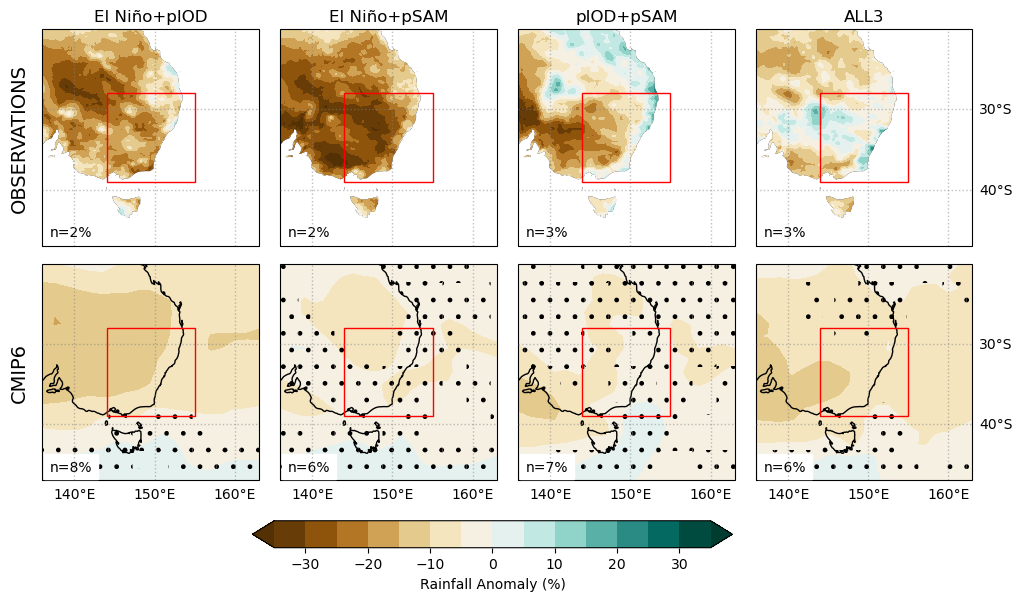

summer


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


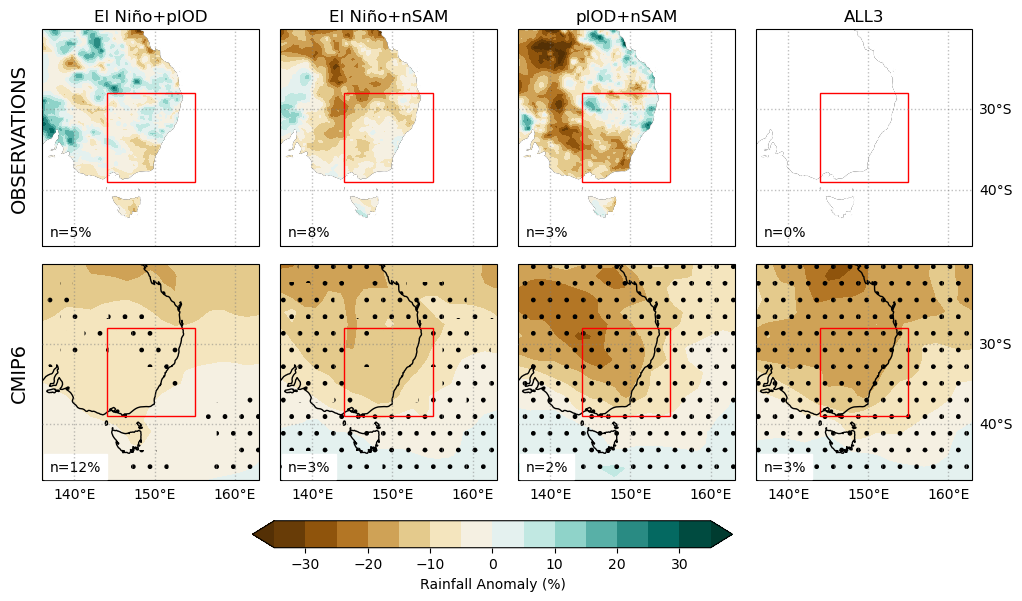

In [16]:
%run {_work_dir}/helpers/impactPlots.ipynb

import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iSeason,ENSO,IOD,SAM in [
        ['winter','El Niño','pIOD','pSAM'],
        ['summer','El Niño','pIOD','nSAM']
    ]:
    print(iSeason)
    for iImpact in ['Rain',
                    # 'Temp'
                   ]:
    
        nRows=2
        nCols=4

        fig=plt.figure(figsize=(nCols*3,nRows*4+1))

        #First row is observations
        with allCompounds[indexSet+iSeason].sel(fire='pos') as firstRow:

            #First cell is ENSO+IOD
            ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+iod',iSeason,iImpact)
            ax.set_title(ENSO+'+'+IOD)
            gl.bottom_labels=False
            gl.right_labels=False

            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('OBSERVATIONS'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            #2nd cell is ENSO only
            ax=plt.subplot(nRows+1,nCols,2,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+sam',iSeason,iImpact)
            ax.set_title(ENSO+'+'+SAM)
            gl.bottom_labels=False
            gl.right_labels=False

            #3rd cell is IOD only
            ax=plt.subplot(nRows+1,nCols,3,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'iod+sam',iSeason,iImpact)
            ax.set_title(IOD+'+'+SAM)
            gl.bottom_labels=False
            gl.right_labels=False


             #4th cell is ALL3
            ax=plt.subplot(nRows+1,nCols,4,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'all3',iSeason,iImpact)
            ax.set_title('ALL3')
            gl.bottom_labels=False

        #Second row is years 2050 to 2099
        if iImpact=='Rain':
            impactXr=cmipPrXr
        elif iImpact=='Temp':
            impactXr=cmipDetrendTsXr
        
        with cmipCompounds[indexSet+iSeason].sel(fire='pos',drop=True) as secondRow:

            #First cell is All3
            ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+iod',iSeason,iImpact,impactXr)
            gl.right_labels=False
            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('CMIP6'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            #2nd cell is ENSO + SAM only
            ax=plt.subplot(nRows+1,nCols,nCols+2,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+sam',iSeason,iImpact,impactXr)
            gl.right_labels=False

            #3rd cell is IOD only
            ax=plt.subplot(nRows+1,nCols,nCols+3,projection=ccrs.PlateCarree())
            cs,gl = singleAnomWithStipling(secondRow,'iod+sam',iSeason,iImpact,impactXr)
            gl.right_labels=False

            ax=plt.subplot(nRows+1,nCols,nCols+4,projection=ccrs.PlateCarree())
            cs,gl = singleAnomWithStipling(secondRow,'all3',iSeason,iImpact,impactXr)

        # add some space between rows
        plt.subplots_adjust(hspace=0.05, wspace=0.1)

        if iImpact=='Rain':
            label = 'Rainfall Anomaly (%)'
        elif iImpact=='Temp':
            label = 'Detrended Temperature Anomaly (°C)'

        #put a color bar on
        ax=fig.add_axes([0.3,0.3,0.4,0.03])
        cbar=plt.colorbar(
            cm.ScalarMappable(cs.norm,cs.cmap),
            orientation='horizontal', 
            cax=ax, 
            extend='both', 
            boundaries=cs.get_array(), 
            label=label
        )

        plt.savefig(f'{_work_dir}/figures/dry'+iImpact+iSeason+'.pdf',bbox_inches='tight')
        
        plt.show()


winter


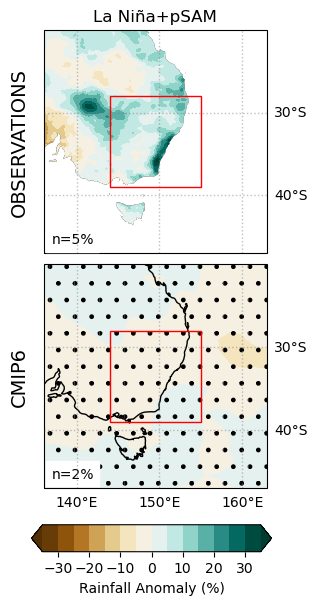

summer


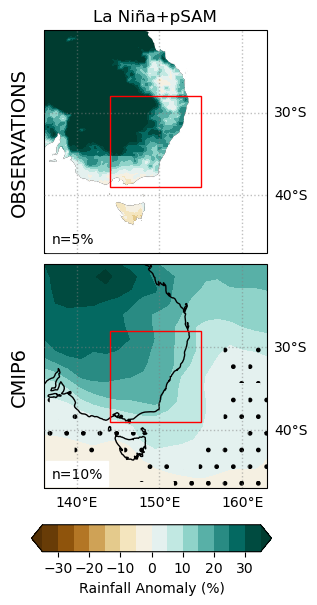

In [18]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iSeason in ['winter','summer']:
    print(iSeason)
    for iImpact in ['Rain',
                    # 'Temp'
                   ]:
    
        nRows=2
        nCols=1

        fig=plt.figure(figsize=(nCols*3,nRows*4+1))

        #First row is observations
        with allCompounds[indexSet+iSeason].sel(fire='neg',drop=True) as firstRow:

            #First cell is ENSO+IOD
            ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+sam',iSeason,iImpact)
            ax.set_title('La Niña+pSAM')
            gl.bottom_labels=False

            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('OBSERVATIONS'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

        #Second row is years CMIP
        if iImpact=='Rain':
            impactXr=cmipPrXr
        elif iImpact=='Temp':
            impactXr=cmipDetrendTsXr
        
        with cmipCompounds[indexSet+iSeason].sel(fire='neg',drop=True) as secondRow:

            #First cell is All3
            ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+sam',iSeason,iImpact,impactXr)
            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('CMIP6'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            
        # add some space between rows
        plt.subplots_adjust(hspace=0.05, wspace=0.1)

        if iImpact=='Rain':
            label = 'Rainfall Anomaly (%)'
        elif iImpact=='Temp':
            label = 'Detrended Temperature Anomaly (°C)'

        #put a color bar on
        ax=fig.add_axes([0.1,0.3,0.8,0.03])
        cbar=plt.colorbar(
            cm.ScalarMappable(cs.norm,cs.cmap),
            orientation='horizontal', 
            cax=ax, 
            extend='both', 
            boundaries=cs.get_array(), 
            label=label
        )

        plt.savefig(f'{_work_dir}/figures/wet'+iImpact+iSeason+'.pdf',bbox_inches='tight')
        
        plt.show()


# Range of trends in CMIP6

In [34]:
%run {_work_dir}/utils/emergence.ipynb

{'whiskers': [<matplotlib.lines.Line2D at 0x1461a416c940>,
 'caps': [<matplotlib.lines.Line2D at 0x1461a416cee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1461a416c670>],
 'medians': [<matplotlib.lines.Line2D at 0x1461a41764c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1461a4176790>],
 'means': []}

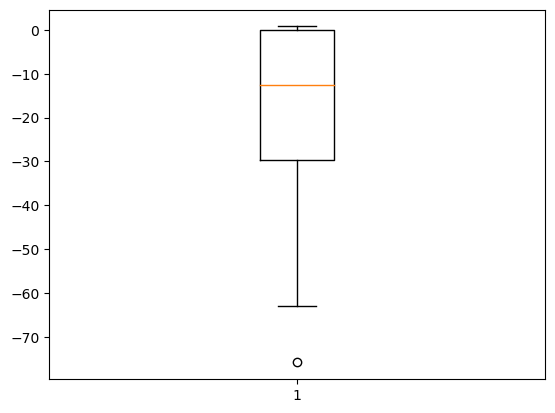

In [55]:
plt.boxplot(
domain(cmipPrXr['Summer Rain']).mean(['lat','lon']).where(
    cmipCompounds[indexSet+'summer'].sel(fire='pos').sel(compound='all3')
).sum('year')
)

In [49]:
cmipCompounds[indexSet+'summer'].sel(fire='pos').sel(compound='all3')

<xarray.DataArray 'nino34DmiSamsummer' (model: 35, year: 4997)>
[174895 values with dtype=float64]
Coordinates:
  * year      (year) int64 1 2 3 4 5 6 7 ... 6193 6194 6195 6196 6197 6198 6199
  * model     (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
    compound  <U4 'all3'
    fire      <U3 'pos'
Attributes:
    indexNames:  ['nino34', 'dmi', 'samSummer']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']